In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [ ]:
features = [0, 1, 2, 3]

mobius = generate_mobius(features, 2)
capacity = mobius_to_capacity(mobius, features)

print("Möbius:")
for i in range(len(mobius)):
    print(f"Mobius of {mobius[i].X} is {mobius[i].mu:.3f}")

print("\nDerived Capacity:")
for c in capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.466
Mobius of [1] is 0.216
Mobius of [2] is 0.115
Mobius of [3] is 0.854
Mobius of [0, 1] is 0.768
Mobius of [0, 2] is 0.423
Mobius of [0, 3] is 0.146
Mobius of [1, 2] is 0.655
Mobius of [1, 3] is 0.908
Mobius of [2, 3] is 0.774

Derived Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.088
Capacity of [1] is 0.041
Capacity of [2] is 0.022
Capacity of [3] is 0.160
Capacity of [0, 1] is 0.272
Capacity of [0, 2] is 0.189
Capacity of [0, 3] is 0.275
Capacity of [1, 2] is 0.185
Capacity of [1, 3] is 0.371
Capacity of [2, 3] is 0.327
Capacity of [0, 1, 2] is 0.496
Capacity of [0, 1, 3] is 0.631
Capacity of [0, 2, 3] is 0.522
Capacity of [1, 2, 3] is 0.661
Capacity of [0, 1, 2, 3] is 1.000


In [4]:
for subset in powerset(features):
    print(f"Subset: {set(subset)}")

Subset: set()
Subset: {0}
Subset: {1}
Subset: {2}
Subset: {3}
Subset: {0, 1}
Subset: {0, 2}
Subset: {0, 3}
Subset: {1, 2}
Subset: {1, 3}
Subset: {2, 3}
Subset: {0, 1, 2}
Subset: {0, 1, 3}
Subset: {0, 2, 3}
Subset: {1, 2, 3}
Subset: {0, 1, 2, 3}


In [5]:
X = np.array([0.2, 0.5, 0.8])
choquet_value = Choquet_classic(X, capacity, verbose=True)
print("Choquet integral:", choquet_value)


val_check: [0, 1, 2] - capacity_observation_i: 0.4963852454028652 - val_check2: [1, 2] - capacity_observation_i_1: 0.18519380032368069
val_check: [1, 2] - capacity_observation_i: 0.18519380032368069 - val_check2: [2] - capacity_observation_i_1: 0.021549387444901282
val_check: [2] - capacity_observation_i: 0.021549387444901282 - val_check2: [] - capacity_observation_i_1: 0.0
Choquet integral: 0.1613000054111476


In [6]:
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))

In [7]:
choquet = Choquet(X=data[0], mu=capacity, version='classic', p=1, q=1)
print(choquet.choquet)
# choquet.Choquet_classic(verbose=True)

0.6997046493186498


In [8]:
X = data[0]
choquet_value = Choquet_classic(X, capacity, verbose=True)
print("Choquet integral:", choquet_value)


val_check: [3, 2, 1, 0] - capacity_observation_i: 1.0 - val_check2: [2, 1, 0] - capacity_observation_i_1: 0.4963852454028652
val_check: [2, 1, 0] - capacity_observation_i: 0.4963852454028652 - val_check2: [1, 0] - capacity_observation_i_1: 0.27242425829520156
val_check: [1, 0] - capacity_observation_i: 0.27242425829520156 - val_check2: [0] - capacity_observation_i_1: 0.08761653885000532
val_check: [0] - capacity_observation_i: 0.08761653885000532 - val_check2: [] - capacity_observation_i_1: 0.0
Choquet integral: 0.6997046493186498


In [9]:
cross = crossover(
    parent1=generate_capacity(enumerate_permute_unit(data[0])), 
    parent2=generate_capacity(enumerate_permute_unit(data[0]))
)
print("\nCrossed Capacity:")
for c in cross:
    print(f"Capacity of {c.X} is {c.mu:.3f}")


Crossed Capacity:
Capacity of [] is 0.000
Capacity of [3] is 0.049
Capacity of [2] is 0.169
Capacity of [1] is 0.135
Capacity of [0] is 0.135
Capacity of [3, 2] is 0.259
Capacity of [3, 1] is 0.268
Capacity of [3, 0] is 0.349
Capacity of [2, 1] is 0.803
Capacity of [2, 0] is 0.426
Capacity of [1, 0] is 0.430
Capacity of [3, 2, 1] is 0.457
Capacity of [3, 2, 0] is 0.471
Capacity of [3, 1, 0] is 0.718
Capacity of [2, 1, 0] is 0.745
Capacity of [3, 2, 1, 0] is 1.000


In [10]:
mutated_mobius = mutate(capacity, mutation_rate=0.2)
print("\nMutated Möbius:")
for i in range(len(mutated_mobius)):
    print(f"Mobius of {mutated_mobius[i].X} is {mutated_mobius[i].mu:.3f}")


Mutated Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.088
Mobius of [1] is 0.000
Mobius of [2] is 0.022
Mobius of [3] is 0.160
Mobius of [0, 1] is 0.191
Mobius of [0, 2] is 0.110
Mobius of [0, 3] is 0.275
Mobius of [1, 2] is 0.185
Mobius of [1, 3] is 0.371
Mobius of [2, 3] is 0.303
Mobius of [0, 1, 2] is 0.496
Mobius of [0, 1, 3] is 0.631
Mobius of [0, 2, 3] is 0.522
Mobius of [1, 2, 3] is 0.656
Mobius of [0, 1, 2, 3] is 1.000


In [11]:
mutated_mu = mutate(capacity, mutation_rate=0.2)
print("\nMutated Möbius:")
for i in range(len(mutated_mu)):
    print(f"Mobius of {mutated_mu[i].X} is {mutated_mu[i].mu:.3f}")


Mutated Möbius:
Mobius of [] is 0.000
Mobius of [0] is 0.088
Mobius of [1] is 0.041
Mobius of [2] is 0.022
Mobius of [3] is 0.075
Mobius of [0, 1] is 0.272
Mobius of [0, 2] is 0.189
Mobius of [0, 3] is 0.363
Mobius of [1, 2] is 0.185
Mobius of [1, 3] is 0.463
Mobius of [2, 3] is 0.327
Mobius of [0, 1, 2] is 0.496
Mobius of [0, 1, 3] is 0.631
Mobius of [0, 2, 3] is 0.522
Mobius of [1, 2, 3] is 0.661
Mobius of [0, 1, 2, 3] is 1.000


Leave one out avec k = 1
SimLevel1: 0.66
SimLevel2: 0.36
SimLevel3: 0.7866666666666666

Result in 5.4779 seconds.
Leave one out avec k = 2
SimLevel1: 0.6666666666666666
SimLevel2: 0.54
SimLevel3: 0.9533333333333334

Result in 5.1070 seconds.
Leave one out avec k = 3
SimLevel1: 0.6666666666666666
SimLevel2: 0.36666666666666664
SimLevel3: 0.9266666666666666

Result in 6.5736 seconds.
Leave one out avec k = 4
SimLevel1: 0.6666666666666666
SimLevel2: 0.28
SimLevel3: 0.9533333333333334

Result in 4.8101 seconds.
Leave one out avec k = 5
SimLevel1: 0.6666666666666666
SimLevel2: 0.36666666666666664
SimLevel3: 0.9066666666666666

Result in 5.1048 seconds.
Leave one out avec k = 6
SimLevel1: 0.6666666666666666
SimLevel2: 0.32666666666666666
SimLevel3: 0.9266666666666666

Result in 4.5571 seconds.
Leave one out avec k = 7
SimLevel1: 0.6666666666666666
SimLevel2: 0.34
SimLevel3: 0.9333333333333333

Result in 4.9887 seconds.
Leave one out avec k = 8
SimLevel1: 0.6666666666666666
SimLevel2: 0.30666

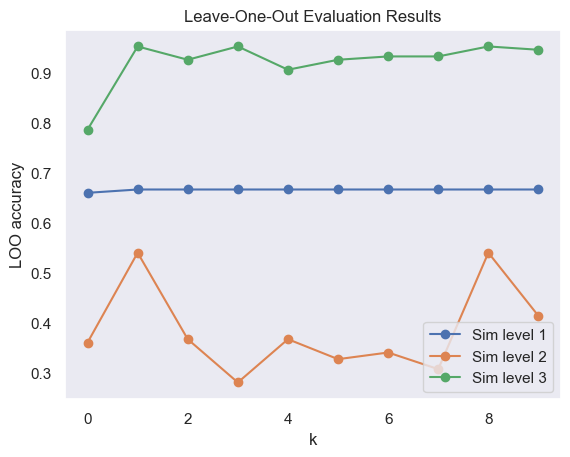

In [12]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mobius = generate_mobius(features)
    mu = mobius_to_capacity(mobius, features)

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()